<a href="https://colab.research.google.com/github/JoeG96/AICT/blob/main/AI_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Datasets/FlagDataset.zip' > /dev/null

Importing

In [ ]:
%matplotlib inline
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
from torchvision import datasets, transforms

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')


CUDA is available. Training on GPU.


In [ ]:
splitfolders.ratio("/content/Flags", output='flagdataset',
                   seed = 1337, ratio=(.70,.15,.15), group_prefix=None, move=False)

Copying files: 1200 files [00:00, 3605.04 files/s]


In [ ]:
#image = mpimg.imread('/content/flagdataset/train/germanyflag/germanyflag (10).jpg')
#plt.imshow(image)
#plt.show()

In [ ]:
# Function for showing images
def imshow(image, ax=None, title=None, normalize=True):
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax



In [ ]:
# Define Transforms
data_dir = 'flagdataset'

batch_size = 32

# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236), # resize to 236x?
                                transforms.RandomRotation(5), # random rotation
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

 # validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel                                                 

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform) #set to =transform for no rotation
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)


torch.Size([32])


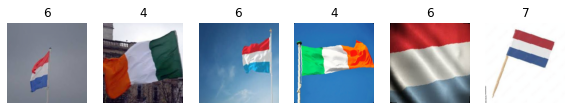

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

fig, axes = plt.subplots(figsize=(10,6), ncols=6)
for ii in range(6):
  ax = axes[ii]
  imshow(images[ii], ax=ax, normalize = True)
  ax.set_title(str(labels[ii].item()))
  torch.Size([8])

In [ ]:
#########################################################################
# use a ResNet18 (50) network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 50 layers
model = models.resnet50(pretrained=True)

# load a pre-trained ResNet network with 18 layers
# model = models.resnet18(pretrained=True)

# # if we use the following code the pre-trained weights are frozen and we only update the final layer
# for param in model.parameters():
#     param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 10)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

# #########################################################################
# #########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# number of epochs to train the model
n_epochs = 50

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available 
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
      # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss) 
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet50_model09122022.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet50_model09122022.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.843275 	Validation Loss: 0.460860
Validation loss decreased (inf --> 0.460860).  Saving model ...
Epoch: 2 	Training Loss: 0.318992 	Validation Loss: 0.479435
Epoch: 3 	Training Loss: 0.213870 	Validation Loss: 0.393607
Validation loss decreased (0.460860 --> 0.393607).  Saving model ...
Epoch: 4 	Training Loss: 0.233079 	Validation Loss: 0.292832
Validation loss decreased (0.393607 --> 0.292832).  Saving model ...
Epoch: 5 	Training Loss: 0.245525 	Validation Loss: 0.172234
Validation loss decreased (0.292832 --> 0.172234).  Saving model ...
Epoch: 6 	Training Loss: 0.145226 	Validation Loss: 0.185086
Epoch: 7 	Training Loss: 0.110680 	Validation Loss: 0.223029
Epoch: 8 	Training Loss: 0.151643 	Validation Loss: 0.113481
Validation loss decreased (0.172234 --> 0.113481).  Saving model ...
Epoch: 9 	Training Loss: 0.162915 	Validation Loss: 0.193837
Epoch: 10 	Training Loss: 0.198773 	Validation Loss: 0.196019
Epoch: 11 	Training Loss: 0.135374 	Validation Lo

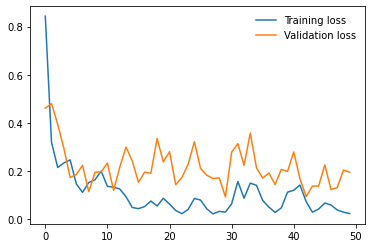

In [ ]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet50_model09122022.pt'))

<All keys matched successfully>

In [ ]:
# 
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
  # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.269712

Test Accuracy of     0: 100% (18/18)
Test Accuracy of     1: 100% (18/18)
Test Accuracy of     2: 100% (18/18)
Test Accuracy of     3: 100% (18/18)
Test Accuracy of     4: 88% (16/18)
Test Accuracy of     5: 77% (14/18)
Test Accuracy of     6: 88% (16/18)
Test Accuracy of     7: 88% (16/18)
Test Accuracy of     8: 100% (18/18)
Test Accuracy of     9: 100% (18/18)

Test Accuracy (Overall): 94% (170/180)


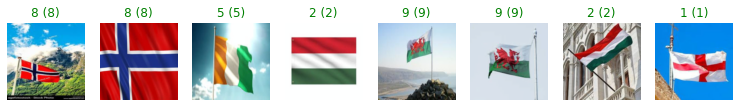

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 8 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(13,8), ncols=8)
for ii in range(8):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
    

# 0 = Denmark
# 1 = England
# 2 = Hungary
# 3 = Iceland
# 4 = Ireland
# 5 = Ivory Coast
# 6 = Luxembourg
# 7 = Netherlands
# 8 = Norway
# 9 = Wales

